# Part 5 - Pipeline, Image and Video

### Let's wrap it up and test it

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays we calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/camera_cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in the saved perspective transformation matrices
# These are the arrays we calculated using cv2.getPerspectiveTransform()
dist_pickle = pickle.load( open( "camera_cal/perspective_trans_matrices.p", "rb" ) )
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

### Define Functions

In [2]:
def filter_WhiteYellow(image):
    """
    Filter the image, showing only a range of white and yellow
    """
    # Filter White
    threshold = 200 
    high_threshold = np.array([255, 255, 255]) #Bright white
    low_threshold = np.array([threshold, threshold, threshold]) #Soft White
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    # Filter Yellow
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing Color-space, HSV is better for object detection
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. 
    high_threshold = np.array([110,255,255]) #Bright Yellow
    low_threshold = np.array([90,100,100]) #Soft Yellow   
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine the two above images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def thresholding(image, M):
    """
    Apply Yellow and White Filter and create binary image
    """
    img_size = (image.shape[1], image.shape[0])
    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(image)
    # Convert image to gray scale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    # Create binary based on detected pixels
    binary_threshold = np.zeros_like(gray)
    binary_threshold[(gray > 0)] = 1
    # Warp the image
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

In [3]:
class Line():
    '''
    Keeps track of line.
    '''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = []

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None

        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line in some units
        self.radius_of_curvature = None

        # distance in meters of vehicle center from the line
        self.line_base_pos = None

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

        # x values for detected line pixels
        self.all_x = None

        # y values for detected line pixels
        self.all_y = None
        

In [4]:
def sliding_window(binary_warped, line):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), color=(0,255,0), thickness=2) # Green
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), color=(0,255,0), thickness=2) # Green
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if line == 'left':
        return leftx, lefty
    elif line == 'right':
        return rightx, righty

    
    
def non_sliding(binary_warped, line):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
        & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
        & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if line == 'left':
        return leftx, lefty
    elif line == 'right':
        return rightx, righty


In [19]:
def pipeline(start_img):
    '''
    Incoming image must be RGB!!
    '''
    start_img = cv2.undistort(start_img, mtx, dist, None, mtx)
    binary_warped = thresholding(start_img, M)

    # Check if line was detected in previous frame:
    if left_line.detected == True:
        leftx, lefty = non_sliding(binary_warped, 'left')
    elif left_line.detected == False:
        leftx, lefty = sliding_window(binary_warped, 'left')
        left_line.detected = True
    if right_line.detected == True:
        rightx, righty = non_sliding(binary_warped, 'right')
    elif right_line.detected == False:
        rightx, righty = sliding_window(binary_warped, 'right')
        right_line.detected = True

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Stash away polynomials
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

    # Calculate radii of curvature in meters
    y_eval = np.max(ploty)  # Where radius of curvature is measured
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    midpoint = np.int(start_img.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (midpoint - middle_of_lane) * xm_per_pix

    # Create an image to draw the lines on
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (start_img.shape[1], start_img.shape[0])
    unwarped = cv2.warpPerspective(color_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    result = cv2.addWeighted(start_img, 1, unwarped, 0.3, 0)
    radius = np.mean([left_curverad, right_curverad])

    # Add radius and offset calculations to top of video
    cv2.putText(result,"L. Lane Radius: " + "{:0.2f}".format(left_curverad/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"R. Lane Radius: " + "{:0.2f}".format(right_curverad/1000) + 'km', org=(50,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)

    return result

In [6]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

In [7]:
import glob

# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

In [8]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

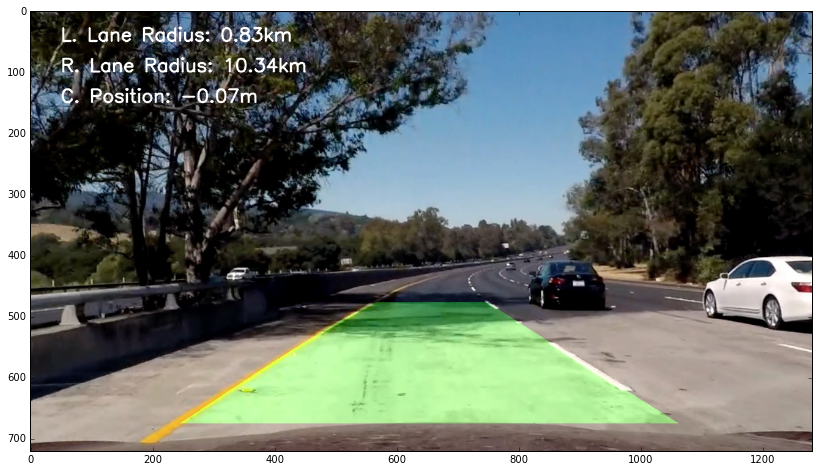

In [20]:
left_line = Line()
right_line = Line()

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = pipeline(img)

plt.imshow(result)


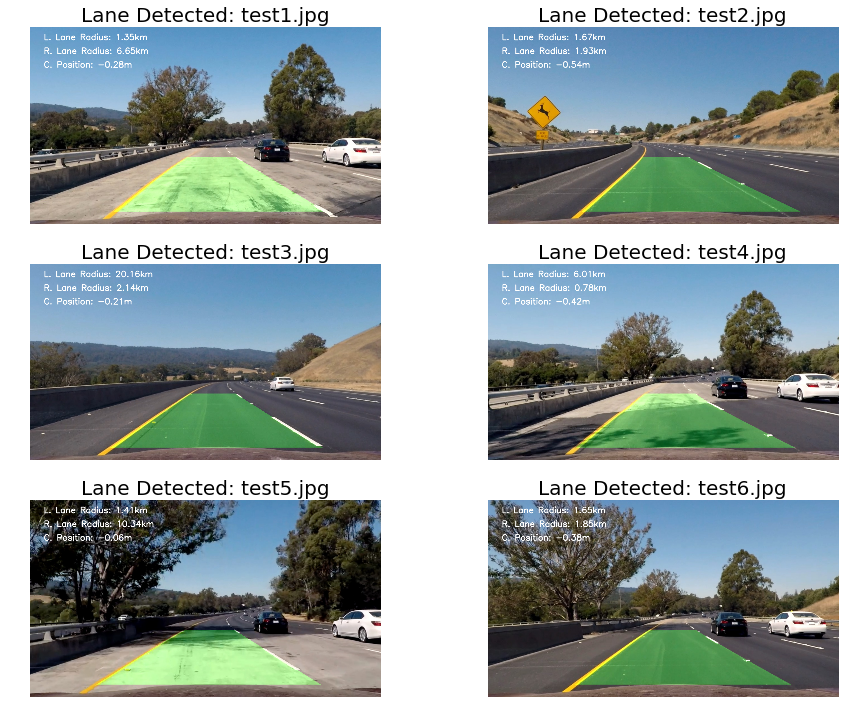

In [21]:
#  Plotting function for images
def plotImages(images, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = python list of images full path
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    from os.path import basename
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
        # load image, change color space, undistort
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply pipeline
        left_line = Line()
        right_line = Line()
        result = pipeline(img)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(result, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

        
plotImages(images, ncols=2, cmap='gray', prefix_label = 'Lane Detected:')

### Teste on videos

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'annotated_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))